# Experiment on Subtask A: Validation
Updated on August 20, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask A is a validation task. The purpose is to determine which of two similar natural language statements is against common sense.

*Example:*  
> Task: Which of the two statements is against common sense?  
> Statement1: He put a turkey into the fridge.  
> Statement2: He put an elephant into the fridge. 

#### Solution:
The experiment will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training and Evaluation 
5. Experiment 

<!-- #### Task Description:
The subtask A is a validation task. The purpose is going to tell which of two similar natural language statements is against common sense.

*Example:* 
        
    Task: Which statement of the two is against common sense?
    Statement1: He put a turkey into the fridge.  
    Statement2: He put an elephant into the fridge.    -->

## 1. General Preparation

Import some common libraries.

In [1]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [2]:
import torch
cuda_id = 3
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:3 - TITAN RTX


Use TensorBoard to record and visualize the results of the experiment.

In [3]:
from torch.utils.tensorboard import SummaryWriter  

# Set TensorBoard
writer_tensorboard = SummaryWriter('./TensorBoard/SubtaskA')

## 2. Data Processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [4]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'Statement 0', 'Statement 1'])
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])['Answer']
    return texts, labels

Read texts and labels from csv file.

In [5]:
train_texts, train_labels = get_info_from_csv(
    '../DataSet/Training Data/subtaskA_data_all.csv',
    '../DataSet/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    '../DataSet/Dev Data/subtaskA_dev_data.csv',
    '../DataSet/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    '../DataSet/Test Data/subtaskA_test_data.csv',
    '../DataSet/Test Data/subtaskA_gold_answers.csv'
)

Let's have a look at the training data.

In [6]:
train_data = pd.concat([train_texts, train_labels], axis=1)
train_data.head()

,ID,Statement 0,Statement 1,Answer
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.,0
1,1,He drinks apple.,He drinks milk.,0
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today",1
3,3,A mosquito stings me,I sting a mosquito,1
4,4,A niece is a person.,A giraffe is a person.,1


### 2.2 Tokenization

Define a function to get a tokenizer.

In [7]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast

def get_tokenizer(model_name):
    if model_name.startswith("bert"):
        return BertTokenizerFast.from_pretrained(model_name)
    if model_name.startswith("distilbert"):
        return DistilBertTokenizerFast.from_pretrained(model_name)
    if model_name.startswith("roberta"):
        return RobertaTokenizerFast.from_pretrained(model_name)

Define a function to do the tokenization.

In [8]:
def tokenization(model_name):
    # Get tokenizer
    tokenizer = get_tokenizer(model_name)

    # Tokenization for texts
    train_encodings = tokenizer(list(train_texts["Statement 0"]), list(train_texts["Statement 1"]), truncation=True, padding=True)
    val_encodings = tokenizer(list(val_texts["Statement 0"]), list(val_texts["Statement 1"]), truncation=True, padding=True)
    test_encodings = tokenizer(list(test_texts["Statement 0"]), list(test_texts["Statement 1"]), truncation=True, padding=True)
    
    return train_encodings, val_encodings, test_encodings

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [9]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Define a function to get all dataset in the form of dataset objects.   
Note that, for different models, we need to use the corresponding tokenizer to process the text data.

In [10]:
def get_dataset(model_name):
    # Tokenization for texts
    train_encodings, val_encodings, test_encodings = tokenization(model_name)

    # Turn encodings and labels into a Dataset object
    train_dataset = ComVEDataset(train_encodings, train_labels)
    val_dataset = ComVEDataset(val_encodings, val_labels)
    test_dataset = ComVEDataset(test_encodings, test_labels)
    
    dataset = {"train_dataset" : train_dataset, "val_dataset" : val_dataset, "test_dataset" : test_dataset}
    return dataset

## 3. Loading the Model and Optimizer

Define a function to load model.

In [11]:
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification

def get_model(model_name):
    if model_name.startswith("bert"):
        model = BertForSequenceClassification.from_pretrained(model_name)
    if model_name.startswith("distilbert"):
        model = DistilBertForSequenceClassification.from_pretrained(model_name)
    if model_name.startswith("roberta"):
        model = RobertaForSequenceClassification.from_pretrained(model_name)
        
    model.to(device)
    return model

Define a function to load optimizer.

In [12]:
from transformers import AdamW

def get_optimizer(model, optimizer_name, learning_rate):
    if optimizer_name == "Adam":
        return AdamW(model.parameters(), lr=learning_rate)

## 4. Training and Evaluation

Prepare some utility functions.

In [13]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [14]:
# Plot function
import matplotlib.pyplot as plt

def plot_loss_and_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, save_name=None):
    
    '''
    Plot 1: Iteration vs Loss
    '''
    name = save_name.split("/")[-1]
    print(name)
    
    # X-axis
    val_loss_X = (np.arange(len(val_loss_list))+1) * int(len(train_loss_list)/len(val_loss_list))  # This is to adjust the X-axis of val_loss. For each epoch, we only get one val_loss, but have len(train_dataset)/batchsize train_loss. Meanwhile, we can deduce that len(train_dataset)/batchsize = len(train_loss_list)/epoch = len(train_loss_list)/len(val_loss_list)

    # plot minimum point of validation loss
    epoch_of_min_loss = np.argmin(val_loss_list)
    val_loss_min_point = (val_loss_X[epoch_of_min_loss], min(val_loss_list))
    plt.axvline(x=val_loss_min_point[0],  color='gray' , linestyle='--', linewidth=0.8)
    # plt.axhline(y=val_loss_min_point[1],  color='gray' , linestyle='--', linewidth=0.8)
    plt.text(x=val_loss_min_point[0]*1.05, y=max(val_loss_list), s="epoch:%s" % (epoch_of_min_loss+1), va="top")
    
    # plot curve
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(val_loss_X, val_loss_list, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs. Iteration")  
    plt.legend()
    
    # save the figure and display it
    if store_img and save_name:
        plt.savefig(save_name + "_Loss.png")
    plt.show()

    
    '''
    Plot 2: Epoch vs Accuracy
    '''
    # X-axis
    acc_X = np.arange(len(train_accuracy_list))+1
    
    # plot maximum point of validation accuracy
    val_acc_max_point = (acc_X[np.argmax(val_accuracy_list)], max(val_accuracy_list))
    plt.axvline(x=val_acc_max_point[0],  color='gray' , linestyle='--', linewidth=0.8)
    plt.axhline(y=val_acc_max_point[1],  color='gray' , linestyle='--', linewidth=0.8)
    plt.scatter(x=val_acc_max_point[0], y=val_acc_max_point[1], color="gray")
    # plt.text(x=val_acc_max_point[0]*0.98, y=val_acc_max_point[1]*1.05, s=tuple([round(x,2) for x in val_acc_max_point]), ha="right") 
    if val_acc_max_point[0] > len(acc_X)-3: 
        plt.text(x=val_acc_max_point[0]*0.98, y=val_acc_max_point[1]*0.98, s=round(val_acc_max_point[1],3), 
                 ha="right", va="top")
    else:
        plt.text(x=val_acc_max_point[0]*1.02, y=val_acc_max_point[1]*0.98, s=round(val_acc_max_point[1],3), 
                 ha="left", va="top")

    # plot curve
    plt.plot(acc_X, train_accuracy_list,"-", label="Training Accuracy")
    plt.plot(acc_X, val_accuracy_list,"-", label="Validation Accuracy")
    plt.xticks(acc_X)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epoch")   
    plt.legend()
    
    # save the figure and display it
    if store_img and save_name:
        plt.savefig(save_name + "_Accuracy.png")
    plt.show()

Prepare the evaluation function.

In [15]:
# Evaluation
import numpy as np
from torch.utils.data import DataLoader
from pandas.core.frame import DataFrame

def evaluate(model, dataset, batch_size=1, process_name=None, info=None):
    # Get data by DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Start evaluation
    model.eval()

    with torch.no_grad():

        correct = 0
        count = 0
        loss_list = list()
        record = {"labels":list(), "predictions":list()}

        pbar = tqdm(data_loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']

            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'Loss': '{:.3f}'.format(loss.item()),
                'Accuracy': '{:.3f}'.format(accuracy),
                'Process': process_name if process_name else 'Evaluation'
            })

            # record the loss for each batch
            loss_list.append(loss.item())
            
            # use TensorBoard to record the loss and accuracy
            if store_tensorboard_event and info and process_name:
                writer_tensorboard.add_scalars("Loss", {"_".join([process_name] + info[:-1]): loss.item()}, info[-1] )
                writer_tensorboard.add_scalars("Accuracy", {"_".join([process_name] + info[:-1]): accuracy}, info[-1])

            # record the results
            record["labels"] += labels.cpu().numpy().tolist()
            record["predictions"] += predictions.cpu().numpy().tolist()

        pbar.close()
        
    # Record the average loss and the final accuracy
    eval_loss = np.mean(loss_list)
    eval_accuracy = accuracy
    
    # Convert evaluation record to a pandas DataFrame object
#     pass
#     df_record = DataFrame(record)
#     df_record.columns = ["Ground Truth","Model Prediction"]
#     df_record = None

    return eval_loss, eval_accuracy, record  

Prepare the training function.

In [16]:
# Training
from torch.utils.data import DataLoader

def train(model, dataset, optimizer, batch_size=16, epoch=10, loss_function=None, target=None, info=None):

    # Get training data by DataLoader
    train_dataset = dataset.get("train_dataset")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Start training
    model.train()

    train_loss_list = list()
    train_accuracy_list = list()
    val_loss_list = list()
    val_accuracy_list = list()
    
    iteration = 0
    for epoch_i in range(epoch):
        print('Epoch %s/%s' % (epoch_i + 1, epoch))
        time.sleep(0.3)

        correct = 0
        count = 0
        loss_list = list()

        pbar = tqdm(train_loader)
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            loss.backward()
            optimizer.step()

            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'Loss': '{:.3f}'.format(loss.item()),
                'Accuracy': '{:.3f}'.format(accuracy),
                'Process': 'Training'
            })

            # record the loss for each batch
            loss_list.append(loss.item())
            
            # use TensorBoard to record the loss and accuracy
            if store_tensorboard_event and info:
                iteration += 1
                writer_tensorboard.add_scalars("Loss", {"_".join(["Training"] + info): loss.item()}, iteration)
                writer_tensorboard.add_scalars("Accuracy", {"_".join(["Training"] + info): accuracy}, iteration)

        pbar.close()

        # record the training loss and accuracy for each epoch
        train_loss_list += loss_list
        train_accuracy_list.append(accuracy)
        
        # Evaluation on validation dataset
        val_dataset = dataset.get("val_dataset")
        val_loss, val_accuracy, record = evaluate(model, val_dataset, batch_size=batch_size, 
                                              process_name="Validation", info=info+[iteration])
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
    
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, record

## 5. Experiment

Experiment: Roberta-Large Adam CrossEntropy LearningRate=1e-05 BatchSize=128 Epoch=15


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas

Epoch 1/15


100%|██████████| 8/8 [00:02<00:00,  2.75it/s, Loss=0.696, Accuracy=0.510, Process=Validation]


Epoch 2/15


100%|██████████| 8/8 [00:03<00:00,  2.41it/s, Loss=0.197, Accuracy=0.916, Process=Validation]


Epoch 3/15


100%|██████████| 8/8 [00:03<00:00,  2.28it/s, Loss=0.139, Accuracy=0.941, Process=Validation]


Epoch 4/15


100%|██████████| 8/8 [00:03<00:00,  2.29it/s, Loss=0.239, Accuracy=0.932, Process=Validation]


Epoch 5/15


100%|██████████| 8/8 [00:03<00:00,  2.33it/s, Loss=0.343, Accuracy=0.930, Process=Validation]


Epoch 6/15


100%|██████████| 8/8 [00:03<00:00,  2.32it/s, Loss=0.430, Accuracy=0.938, Process=Validation]


Epoch 7/15


100%|██████████| 8/8 [00:03<00:00,  2.28it/s, Loss=0.436, Accuracy=0.935, Process=Validation]


Epoch 8/15


100%|██████████| 8/8 [00:03<00:00,  2.26it/s, Loss=0.468, Accuracy=0.934, Process=Validation]


Epoch 9/15


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, Loss=0.512, Accuracy=0.928, Process=Validation]


Epoch 10/15


100%|██████████| 8/8 [00:03<00:00,  2.33it/s, Loss=0.408, Accuracy=0.920, Process=Validation]


Epoch 11/15


100%|██████████| 8/8 [00:03<00:00,  2.34it/s, Loss=0.401, Accuracy=0.935, Process=Validation]


Epoch 12/15


100%|██████████| 8/8 [00:03<00:00,  2.33it/s, Loss=0.219, Accuracy=0.936, Process=Validation]


Epoch 13/15


100%|██████████| 8/8 [00:03<00:00,  2.22it/s, Loss=0.315, Accuracy=0.927, Process=Validation]


Epoch 14/15


100%|██████████| 8/8 [00:03<00:00,  2.27it/s, Loss=0.365, Accuracy=0.937, Process=Validation]


Epoch 15/15


100%|██████████| 8/8 [00:03<00:00,  2.33it/s, Loss=0.202, Accuracy=0.933, Process=Validation]


Roberta-Large_Adam_CrossEntropy_LearningRate=1e-05_BatchSize=128_Epoch=15


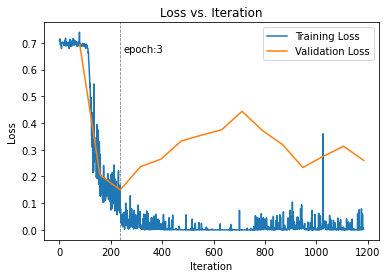

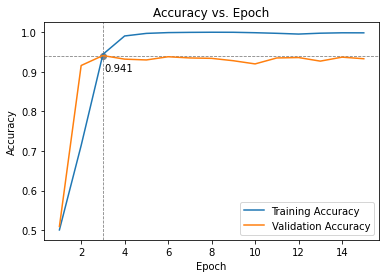

In [17]:
import csv
import os

# Settings: whether to store the experiment results.
store_img = True
store_tensorboard_event = True

"""
Select the Model and the Hyperparameters
"""
# Select the model.
# Check the Pretrained models on https://huggingface.co/transformers/pretrained_models.html
# Options: ["bert-base-uncased" , "distilbert-base-uncased", "roberta-base", "roberta-large"]
model_name = "roberta-large"

# Select the optimizer.
optimizer_name = 'Adam'

# Select the loss function.
loss_name = 'CrossEntropy'

# Select the learning rate list.
# learning_rate_list = [10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]               # learning rate list
learning_rate_list = [1e-5]                                               # learning rate list

# Select the batch size list.
# batch_size_list = [2,4,8,16,32,64,128,256]                              # batch size list
batch_size_list = [128]                                                   # batch size list

# Select the epoch.
epoch = 15
    

"""
Start Experiments with Selected Model and Hyperparameters.
"""
# Get the dataset via using the specific model tokenizer.
dataset = get_dataset(model_name)

# Create a directory for this experiment.
task_directory = "ExperimentResult_A"
experiment_name = "_".join([time.strftime("%Y%m%d_%H%M", time.localtime()), 
                            model_name.title(), optimizer_name, loss_name, "Epoch=%s" % epoch])
os.makedirs("./%s/%s" % (task_directory, experiment_name))

# Experiment and store the results in a CSV file.
file_name =  "./%s/%s/%s.csv" % (task_directory, experiment_name, experiment_name)
with open(file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Model", "Optimizer", "Loss Function", "Learning Rate", "Batch Size", "Test Epoch", 
                     "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy", 
                     "Highest Accuracy", "Occurred in which Epoch"])
    
    for learning_rate in learning_rate_list:
        
        for batch_size in batch_size_list:
            experiment_info = [model_name.title(), optimizer_name, loss_name, 
                               "LearningRate=%s" % learning_rate, "BatchSize=%s" % batch_size, "Epoch=%s" % epoch]
            print("Experiment:", " ".join(experiment_info))
            
            # Initialize the model
            model = get_model(model_name)
            
            # Get the Optimizer
            optimizer = get_optimizer(model, optimizer_name, learning_rate)
            
            # Training
            train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, record = train(
                model = model,
                dataset = dataset,
                optimizer = optimizer,
                batch_size = batch_size,
                epoch = epoch,
                info = experiment_info
            )
            
            # Plot the result
            save_name = "./%s/%s/%s" % (task_directory, experiment_name, "_".join(experiment_info))
            plot_loss_and_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, save_name)
            
            # Record the validation result 
            writer.writerow([model_name.title(), optimizer_name, loss_name, learning_rate, batch_size, epoch, 
                             train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list,
                             max(val_accuracy_list), np.argmax(val_accuracy_list)+1])
            
            torch.cuda.empty_cache()

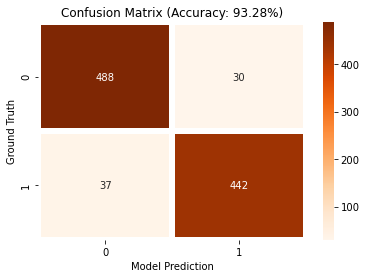

In [18]:
# Display the Confusion Matrix of the last experiment result.
import seaborn as sns

# Convert test record to a pandas DataFrame object
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# Display the Confusion Matrix
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()